# E 11. 뉴스 요약봇 만들기

`16 FEB 2021`


#### 목차 

> 1. 필요한 라이브러리 import
> 2. 데이터 준비 및 전처리
> 3. 어텐션 메커니즘 사용하기 (추상적 요약)
> 4. Summa을 이용해서 추출적 요약해보기
> 5. 비교

## 1. 필요한 라이브러리 import 

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac17/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. 데이터 준비하기
아래와 같이 작업환경을 구성합니다

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
40665,Vadodara firm defrauds 11 banks of over Ã¢ÂÂ¹...,The CBI has registered a case against Vadodara...
73043,Delhi Police busts casino run by former model,The Delhi Police raided an illegal casino in a...
28238,"Tunisia net WC's 2,500th goal, win WC match af...",Tunisia on Wednesday defeated Panama in a matc...
15688,"Ronaldo gets 1-match ban, clear to face former...",Juventus forward Cristiano Ronaldo is clear to...
93987,Army was cheated to pay rent for land in PoK: ...,Defence Minister Arun Jaitley on Tuesday said ...
92810,Only 1 Indian extradited from UK since treaty ...,Ever since India and the UK signed the Extradi...
56402,Fuel-exhausted white dwarf stars are 'binge ea...,A UK-based study has found that white dwarfs g...
317,"5 Maoists killed, 1 other injured in encounter...",At least five Maoists have been killed and one...
75562,Cattle ban rules were never laid before the Pa...,The response to an RTI which challenged cattle...
21148,"Hats off to SRK, Gauri on letting Suhana enter...","Actress Kajol, while speaking about Shah Rukh ..."


In [4]:
data = data[['headlines','text']]
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
#랜덤한 15개 샘플 출력
data.sample(15)


,headlines,text
74107,Gurugram civic body to revive 4 ponds for stor...,The Municipal Corporation of Gurugram (MCG) ha...
64187,"Daisy Shah, Saqib Saleem to star in Salman Kha...",Actors Daisy Shah and Saqib Saleem will featur...
80726,Players change underwear at Wimbledon since it...,"Boys' doubles top seeds, Hungary's Zsombor Pir..."
74347,Tucked towel in IPL 2013 made me feel like Don...,Sreesanth has claimed that he tucked in a towe...
28440,Our identity was taken away: TaxiForSure found...,While talking about Ola's takeover of his star...
71592,"I am not going anywhere, says HPE CEO Meg Whit...",Hewlett Packard Enterprise (HPE) CEO Meg Whitm...
51023,'Saat Samundar Paar' is inspired by English so...,The song 'Saat Samundar Paar' from the 1992 fi...
50398,President Kovind launches Pulse Polio programm...,President Ram Nath Kovind on Saturday launched...
64095,No takers for Taj Mahal in Govt's 'Adopt a Her...,The Ministry of Tourism found no private entit...
61234,Indian spinner once bowled 20 overs without co...,Madhya Pradesh's left-arm spinner Manish Majit...


## 3. 데이터 전처리하기 (추상적 요약)

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

In [6]:
# 중복 샘플 유무 확인 

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
#데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거할 수 있어요.

data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))


전체 샘플수 : 98360


In [8]:
#데이터 프레임에 Null 값이 있는지 .isnull().sum() 활용해 확인해보자 

print(data.isnull().sum())


headlines    0
text         0
dtype: int64


In [9]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거

살아남은 98,360개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.

예를 들어서 'it'll'은 'it will'과 같고, 'mustn't과 'must not'은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.

이러한 방법론을 텍스트 처리에서는 `텍스트 정규화(text normalization)`라고 해요.

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


**불용어(stopwords) = 자연어 처리를 할 때 실질적 별 도움이 되지 않는 단어들**

In [11]:
# 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거해보자 

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))


불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
#데이터 전처리 함수 설계
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해볼까요.

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.



In [13]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
# headlines 열 전처리
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
#전처리 후의 결과를 다시 데이터프레임에 저장합니다.

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값(공백)을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

혹시 전처리 과정에서 빈 값이 생겼다면 Null 값으로 변경한 후에 Null 값을 가진 샘플이 생겼는지 확인합니다.

In [17]:
# null 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

headlines 와 text에서는 null값을 가진 샘플이 없네요.


In [18]:
# null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### 데이터 전처리하기 (2) 훈련데이터와 테스트 데이터나누기

- 이제 text 열과 headlines 열에 대해서 길이 분포를 확인해보겠습니다.



텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


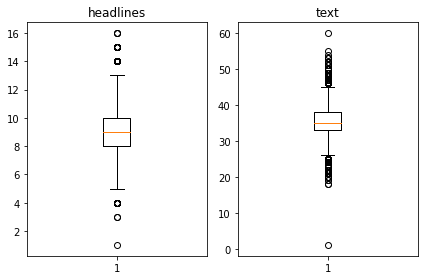

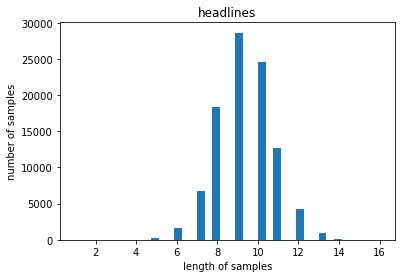

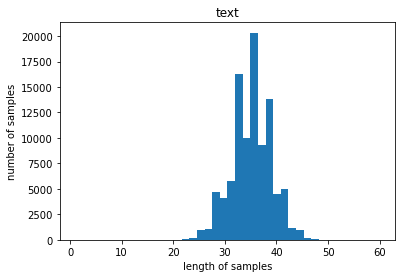

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

원문 텍스트는 대체적으로 50이하의 길이를 가집니다. 또한, 평균 길이는 35입니다. 

요약의 경우에는 대체적으로 14이하의 길이를 가지며 평균 길이는 9입니다.

여기서 패딩의 길이를 정하는데 평균 길이보다는 크게 잡아 각각 40과 10로 결정하는게 좋았을 것 같다. 

노드를 따라하면서 그냥 50,14로 결정했다. 

In [20]:
# 50과 14라는 이 두 길이가 얼마나 많은 샘플들의 길이보다 큰지 확인해보겠습니다.

text_max_len = 50
headlines_max_len = 14

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715


- headlines 열은 길이가 14 이하인 비율이 99%입니다. 약 1%의 샘플이 길이 50보다 큽니다.


- Text 열은 길이가 50 이하인 비율이 99%입니다. 약 1%의 샘플이 길이 50보다 큽니다.



In [23]:
#정해준 최대 길이보다 큰 샘플들은 제거

data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98324


## 시작토큰 종류토큰저장

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 

시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명하고 앞, 뒤로 추가하겠습니다.

In [24]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


### 훈련데이터, 테스트데이터 분리

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56424 85767 42429 ... 15588  7784 95762]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19664


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


###  3. 데이터 전처리 - 정수 인코딩

- 단어 집합(vocaburary) 만들기 및 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔줘야 한다.

이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요한데 이 과정을 `단어 집합(vocaburary)을 만든다`고 표현해요. 

훈련 데이터에 대해서 단어 집합을 만들어볼게요.
우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.


In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69739
등장 빈도가 6번 이하인 희귀 단어의 수: 47615
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22124
단어 집합에서 희귀 단어의 비율: 68.27600051621044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5041813910438355


In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[702, 271, 284, 3666, 4000, 7, 129, 7672, 10, 766, 2061, 2483, 54, 31, 7672, 325, 1574, 478, 1740, 1776, 353, 1187, 2483, 4853, 345, 10, 339, 6497, 271, 7248], [1945, 2212, 71, 444, 3351, 2505, 1382, 146, 132, 143, 3080, 304, 3, 13, 3936, 1941, 4216, 66, 6890, 1751, 2575, 56, 3351, 445, 7780, 286, 2309, 2396, 678, 1972, 1941, 1624, 1], [4975, 16, 7673, 3937, 69, 95, 39, 1600, 30, 2692, 376, 3, 894, 1519, 729, 1499, 39, 54, 31, 17, 3030, 2460, 39, 1770, 4975]]


- headline data도 똑같이 진행 

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30112
등장 빈도가 5번 이하인 희귀 단어의 수: 19700
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10412
단어 집합에서 희귀 단어의 비율: 65.42242295430393
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.658224784260261


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 509, 45, 14, 1492, 1177, 63], [1, 55, 20, 347, 17, 225, 4, 118, 397], [1, 1665, 116, 15, 1824, 249], [1, 820, 4, 9, 329, 393, 47], [1, 23, 126, 171, 3, 810, 169, 1510, 7, 1108]]
target
decoder  [[509, 45, 14, 1492, 1177, 63, 2], [55, 20, 347, 17, 225, 4, 118, 397, 2], [1665, 116, 15, 1824, 249, 2], [820, 4, 9, 329, 393, 47, 2], [23, 126, 171, 3, 810, 169, 1510, 7, 1108, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 78650
훈련 레이블의 개수 : 78650
테스트 데이터의 개수 : 19662
테스트 레이블의 개수 : 19662


/home/ssac17/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩하기

앞서 계산해둔 최대 길이로 맞추어 훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행합니다.

In [39]:
# padding 
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 4. 어텐션 메커니즘 사용하기 (추상적 요약)

#### seq2seq + attention으로 요약 모델 설계 및 훈련시키기


우선 함수형 API를 이용해서 인코더를 설계해 볼게요.




In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작 , 인코더는 LSTM 층을 3개 쌓습니다.
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더를 설계해보겠습니다. 단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [41]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [42]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

총 3,633,104개의 파라미터를 가진 모델이 설계됩니다. 이제 모델을 컴파일합니다.

### 어텐션 메커니즘

어텐션 메커니즘을 사용할 예정이므로 위에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계해보겠습니다.

In [43]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계합니다.

In [44]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 115s 373ms/step - loss: 3.3465 - val_loss: 3.0793
Epoch 2/50
308/308 [==============================] - 119s 388ms/step - loss: 2.9215 - val_loss: 2.8194
Epoch 3/50
308/308 [==============================] - 125s 407ms/step - loss: 2.6996 - val_loss: 2.6382
Epoch 4/50
308/308 [==============================] - 124s 403ms/step - loss: 2.5373 - val_loss: 2.5167
Epoch 5/50
308/308 [==============================] - 122s 396ms/step - loss: 2.4158 - val_loss: 2.4195
Epoch 6/50
308/308 [==============================] - 128s 416ms/step - loss: 2.3207 - val_loss: 2.3562
Epoch 7/50
308/308 [==============================] - 124s 404ms/step - loss: 2.2397 - val_loss: 2.2975
Epoch 8/50
308/308 [==============================] - 123s 398ms/step - loss: 2.1711 - val_loss: 2.2547
Epoch 9/50
308/308 [==============================] - 117s 381ms/step - loss: 2.1117 - val_loss: 2.2192
Epoch 10/50
308/308 [==============================] - 111s 360m

학습 과정하면서 기록된 훈련 데이터의 손실과 테스트 데이터의 손실 히스토리를 시각화하여 출력합니다

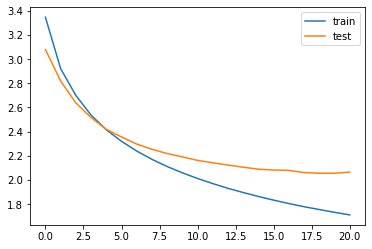

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

테스트 데이터의 손실이 지속적으로 줄어들다가 어느 순간부터 정체하는걸 알 수 있습니다. 

### 인퍼런스 모델 구현하기

In [47]:
#테스트에 필요한 3개의 사전 만들기 

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있습니다. 다시 새로운 seq2seq 모델을 만들겠습니다. 우선 인코더를 정의합니다.



In [48]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [49]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

테스트 단계를 위한 모델이 완성되었습니다. 테스트를 위해 사용되는 함수 decode_sequence를 설계합니다.

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 5.  실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

테스트 단계에서 원문과 실제 요약문, 예측 요약문을 비교하기 위해 정수 시퀀스를 텍스트 시퀀스로 만드는 함수를 설계합니다.

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
테스트 샘플 중 50번부터 100번까지 테스트해봅시다.

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : canadian technology company friday said acquire us based cybersecurity firm billion cash former mobile phone giant said acquisition would enable add artificial intelligence capabilities existing software products uses machine learning pre cyber attacks occur 
실제 요약 : to buy firm for crore 
예측 요약 :  us based firm to buy us based for billion


원문 : canadian judge sparked outrage saying year old sexual assault victim little pretty face may bit year old attacker attention comments came light week made judge jean paul may heard sexual assault allegations 
실제 요약 : sexual assault victim by canadian judge 
예측 요약 :  judge judge gets years for raping minor


원문 : outgoing congress president sonia gandhi contesting general elections uttar pradesh daughter priyanka gandhi vadra said saturday vadra added mother woman seen rahul gandhi said tough road ahead think man brave enough 
실제 요약 : sonia to contest elections from priyanka 
예측 요약 :  sonia gandhi is sachin gandhi


원문 : lawyer representing

예측 요약 :  uk app app to allow internet to women


원문 : startups crore angel funding exempted giving angel tax department industrial policy promotion reportedly said benefit startups received funding angel investors network separate committee set startups recognition reports said citing official 
실제 요약 : no tax on startups with up to cr funding reports 
예측 요약 :  startup raises crore funding


원문 : expelled aiadmk leader vk sasikala parole plea rejected karnataka prisons department tuesday application department asked submit fresh application details sasikala sought day parole visit husband hospitalised liver kidney failure 
실제 요약 : plea rejected over 
예측 요약 :  aiadmk demands ban on sale of


원문 : tamil nadu forest department conducted cleaning drive gulf much kg waste including packets plastic water bottles sea notably past several years department warning people area 
실제 요약 : tamil nadu of 
예측 요약 :  kg plastic waste in tn


원문 : amazon plans open many amazon go stores year according rep

### 추출적 요약 해보기
앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

패키지 설치
먼저 필요한 패키지를 아래와 같이 설치해 주세요.

## 6. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

#### summa 다운로드

`$ pip install summa`

In [56]:
import requests
from summa.summarizer import summarize

In [57]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [58]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summa 사용하기 (추출적 요약)
text (str) : 요약할 테스트.
ratio (float, optional)– 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [59]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [60]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [61]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [62]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [63]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [66]:
for i in range(50):
    print('원문     : {}'.format(data['text'][i]))
    print('실제 요약 : {}'.format(data['headlines'][i]))
    print('예측 요약 : {}'.format(summarize(data['text'][i], ratio=0.6, words=15)))
    print('\n')

원문     : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문     : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of 

# 회고

## 느낀점 

- 추상적 요약 

원문 : hollywood celebrities including taylor swift perry condemned blast ariana grande uk concert taylor tweeted thoughts prayers tears affected manchester tragedy tonight sending love justin wrote thoughts prayers affected act manchester need better 

실제 요약 : blast at concert 

예측 요약 :  new york to honour tribute to




- 추출적 요약 

원문     : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike

예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.





- 추상적 요약 보다 추출적 요약이 확실히 추상적 요약보다 확실히 난이도가 있다고 한다.예측 요약은 어색한 부분이 많다고 느껴진다. 

- 텍스트 요약은 추출적, 추상적 요약 뿐만 아니라 어떤 관점을 가졌느냐에 따라서 정말 다양하게 나눌 수 있다는 것을 알게 되었다. 내용범위, 학습 방법(지도학습 vs 비지도학습), 요약문 스타일에 따라(지시적 vs 정보적 ), 이용자 맞춤(개인화 vs 업데이트) 등등 정~~ 말 다양하다. 영어로된 텍스트를 가지고 진행하다 보니 한국어 요약을 찾아보면서 여러 언어가 섞인 경우도 궁금했었다. 영어 논문을 읽고 한국어 요약문을 작성하는 것도 복잡하겠지만 가능하겠지 싶었다. 접근 방법도 정말 다양하고 아직 자연어 처리의 빙산의 일각을 배우고있다고 느꼈다. NLP분야를 가지고 어떻게 활용하고 싶은지에 대해서 좀더 깊이있게 생각해봐야겠다고 느꼈다. 

# 더 알아보기 

[TextRank 기법을 이용한 핵심 어구 추출 및 텍스트 요약](https://bab2min.tistory.com/552)

[자동 요약 기법의 연구 동향 정리](https://bab2min.tistory.com/625)

[딥 러닝을 이용한 자연어 처리 입문 ](https://wikidocs.net/72820)